In [1]:
#!/usr/bin/env python

# Conditional_analysis.ipynb

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import netCDF4
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
import datetime
import pandas as pd
import subprocess
from calendar import monthrange
import pandas as pd
import datetime
import sys 
import shapefile as shp
import matplotlib.path as mplPath
from scipy.stats import norm
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from calendar import monthrange
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



In [3]:
TimeHH = pd.date_range(datetime.datetime(1980, 1, 1,0), end=datetime.datetime(2020, 12, 31,23), freq='h')
TimeDD = pd.date_range(datetime.datetime(1980, 1, 1,0), end=datetime.datetime(2020, 12, 31,23), freq='d')
TimeMM = pd.date_range(datetime.datetime(1980, 1, 1,0), end=datetime.datetime(2020, 12, 31,23), freq='m')
years = np.unique(TimeMM.year)
PlotDir = ''
    
# pre-processed data dir
data_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/Wind_analyis/derived_data/conditional_data/v1/' 
save_dir = data_dir

### Read in the pre-processed data

In [4]:
for yy in tqdm(range(len(years))):
    data = np.load(data_dir + str(years[yy]) + '-JJA_conditional-data.npz')
    
    focus_area = data['focus_area']
    area_types = data['area_types']
    var_name = data['var_name']
    TimeMM = data['TimeMM']
    var_stats = data['var_stats']
    area_coverages = data['area_coverages']
    non_convective_UV10 = data['non_convective_UV10']
    lon_wrf = data['lon_wrf']
    lat_wrf = data['lat_wrf']
    wrf_region_masks = data['wrf_region_masks']
    
    if yy == 0:
        shape = var_stats.shape
        var_stats_all = np.zeros((len(years), shape[0], shape[1], shape[2], shape[3], shape[4])); var_stats_all[:] = np.nan
        area_coverages_all = np.zeros((len(years), shape[0], shape[1], len(area_types))); area_coverages_all[:] = np.nan
        non_convective_UV10_all = np.zeros((len(years), shape[0], shape[1], shape[2])); non_convective_UV10_all[:] = np.nan
    var_stats_all[yy,:] = var_stats
    area_coverages_all[yy,:] = area_coverages
    non_convective_UV10_all[yy,:] = non_convective_UV10

100%|██████████| 41/41 [02:30<00:00,  3.67s/it]


In [5]:
### Bootstrap days in year to assess uncertainties in trend
from random import randrange
bs_samples = 1000
area = '>=20m/s' # ['<=241Tb', '>=40dBZ', '>=10m/s', '>=20m/s']
data = np.copy(area_coverages_all[:,:,12,list(area_types).index(area)])
data = np.reshape(data, (data.shape[0], int(data.shape[1]/24),24))
bs_dataset = np.zeros((data.shape[0], data.shape[1], data.shape[2], bs_samples)); bs_dataset[:] = np.nan
for bs in tqdm(range(bs_samples)):
    for dd in range(data.shape[1]):
        rand_int = randrange(data.shape[1])
        bs_dataset[:,dd,:,bs] = data[:,rand_int,:]

100%|██████████| 1000/1000 [00:00<00:00, 1101.72it/s]


In [6]:
### Bootstrap temperature drop
bs_samples = 1000
st = 0
pp=0
var = 't2_dt' # ['cape', 'dcape', 'uv10', 'cpi', 't2_dt', 'Tb', 'Z']
data = np.copy(var_stats_all[:,:,:,pp,st,list(var_name).index(var)])
data = np.reshape(data, (data.shape[0], int(data.shape[1]/24),24, data.shape[2]))
bs_dataset_t2_dt = np.zeros((data.shape[0], data.shape[1], data.shape[2], data.shape[3], bs_samples)); bs_dataset_t2_dt[:] = np.nan
for bs in tqdm(range(bs_samples)):
    for dd in range(data.shape[1]):
        rand_int = randrange(data.shape[1])
        bs_dataset_t2_dt[:,dd,:,:,bs] = data[:,rand_int,:,:]
        
diff_bs = np.nanpercentile(bs_dataset_t2_dt[-20:,:,:,:,:], 50, axis=(0,1,2)) - \
          np.nanpercentile(bs_dataset_t2_dt[:20,:,:,:,:], 50, axis=(0,1,2))

100%|██████████| 1000/1000 [00:41<00:00, 24.23it/s]


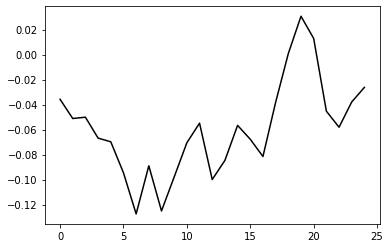

In [7]:
pp = 0
st = 0

var = 't2_dt' # ['cape', 'dcape', 'uv10', 'cpi', 't2_dt', 'Tb', 'Z']
# plt.plot(np.nanpercentile(var_stats_all[:20,:,:,pp,st,list(var_name).index(var)], 50, axis=(0,1)), c='k')
# plt.plot(np.nanpercentile(var_stats_all[-20:,:,:,pp,st,list(var_name).index(var)], 50, axis=(0,1)), c='r')

plt.plot(np.nanpercentile(var_stats_all[-20:,:,:,pp,st,list(var_name).index(var)], 99, axis=(0,1)) - 
         np.nanpercentile(var_stats_all[:20,:,:,pp,st,list(var_name).index(var)], 99, axis=(0,1)), c='k')


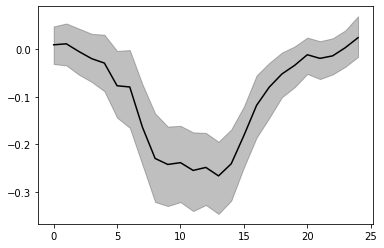

In [8]:
pp = 0
st=0
va=var = 't2_dt' # ['cape', 'dcape', 'uv10', 'cpi', 't2_dt', 'Tb', 'Z']
plt.plot(np.nanpercentile(var_stats_all[-20:,:,:,pp,st,list(var_name).index(var)], 50, axis=(0,1)) - 
         np.nanpercentile(var_stats_all[:20,:,:,pp,st,list(var_name).index(var)], 50, axis=(0,1)), c='k')



plt.fill_between(range(25), np.percentile(diff_bs, 10, axis=1), 
                 y2 = np.percentile(diff_bs, 90, axis=1), color='k', alpha=0.25)


# plt.plot(np.nanmean(var_stats_all[-15:,:,:,pp,st,list(var_name).index(var)], axis=(0,1)), c='r')

In [9]:
var_stats_all.shape

(41, 2208, 25, 101, 3, 7)

        Plot map to: JJA_conditional-changes.pdf


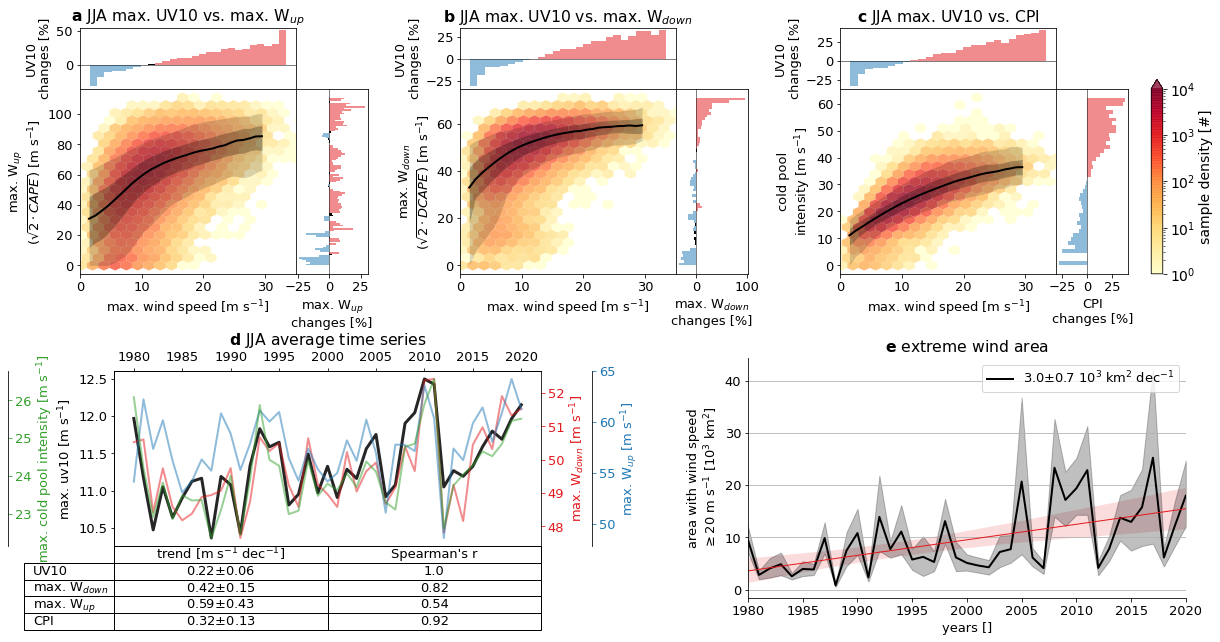

In [39]:
pp=100
ar = 1
dt = -1

fig = plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 13})
rgsLableABC=list(string.ascii_lowercase)

foc_vars = ['CAPE', 'DCAPE', 'CPI']
foc_vars_derived = ['max. W$_{up}$', 'max. W$_{down}$', 'CPI']
x_size = 0.25
x_space = 0.08
for va in range(len(foc_vars)):
    gs1 = gridspec.GridSpec(4,4)
    gs1.update(left=0.05+(x_size+x_space)*va, right=0.05+(x_size+x_space)*va+x_size,
       bottom=0.57, top=0.95,
       wspace=0, hspace=0)
    
    ax = plt.subplot(gs1[1:,:3])
    uv_sel = var_stats_all[:,:,12,pp,ar,list(var_name).index('uv10')]
    if foc_vars[va] == 'CAPE':
        wmax_sel = (2*var_stats_all[:,:,12,pp,ar,list(var_name).index('cape')])**0.5
        axlabel = 'max. W$_{up}$\n($\sqrt{2 \cdot CAPE}$) [m s$^{-1}$]'
    if foc_vars[va] == 'DCAPE':
        wmax_sel = (2*var_stats_all[:,:,12,pp,ar,list(var_name).index('dcape')])**0.5
        axlabel = 'max. W$_{down}$\n($\sqrt{2 \cdot DCAPE}$) [m s$^{-1}$]'
    if foc_vars[va] == 'CPI':
        wmax_sel = var_stats_all[:,:,12,pp,ar,list(var_name).index('cpi')]
        axlabel = 'cold pool\nintensity [m s$^{-1}$]'

    image = plt.hexbin(uv_sel.flatten(), wmax_sel.flatten(), cmap = 'YlOrRd', 
                       gridsize=20, mincnt=1, alpha = 0.75, linewidths=0, vmax=10000, bins='log')

    x_bin = np.arange(0,100,1)
    x_binc = (x_bin[1:] + x_bin[:-1])/2
    overlap = 1 # m/s
    percentiles = (1,5,25,50,75,95,99)
    bw_bins_cape = np.zeros((len(x_binc), len(percentiles))); bw_bins_cape[:] = np.nan
    for ii in range(len(x_binc)):
        data_sel = (uv_sel >= x_bin[ii]-overlap) & (uv_sel < x_bin[ii+1]+overlap)
        if sum(data_sel) > 100:
            bw_bins_cape[ii,:] = np.percentile(wmax_sel[data_sel], percentiles)

    plt.fill_between(x_binc, bw_bins_cape[:,1], y2=bw_bins_cape[:,5], 
                     color='k', alpha=0.15, linewidths=0)
    plt.fill_between(x_binc, bw_bins_cape[:,2], y2=bw_bins_cape[:,4], 
                     color='k', alpha=0.25, linewidths=0)
    plt.plot(x_binc, bw_bins_cape[:,3], c='k', lw=2)

    ax.set_xlabel('max. wind speed [m s$^{-1}$]')
    ax.set_ylabel(axlabel)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim([0,35])
    
    # show pdf shift
    ax2 = plt.subplot(gs1[0,:3])
    # do bootstrapping on this data to test for stat. significance
    bs_samples = 100
    hist_curr_samples = np.zeros((bs_samples, 2, len(x_binc))); hist_curr_samples[:] = np.nan
    for bs in range(bs_samples):
        rand_years = np.array([randrange(0, 19) for ii in range(20)])
        past_years = uv_sel[:20][rand_years]
        hist_past = np.array([
                            np.sum((past_years.flatten() >= x_bin[ii]-overlap) & 
                            (past_years.flatten() < x_bin[ii+1]+overlap))
                         for ii in range(len(x_binc))
                         ])
        curr_years = uv_sel[-20:][rand_years]
        hist_curr = np.array([
                            np.sum((curr_years.flatten() >= x_bin[ii]-overlap) & 
                            (curr_years.flatten() < x_bin[ii+1]+overlap))
                         for ii in range(len(x_binc))
                         ])
        hist_curr_samples[bs,0,:] = hist_past
        hist_curr_samples[bs,1,:] = hist_curr

    change = ((hist_curr_samples[:,1,:]-hist_curr_samples[:,0,:])/hist_curr_samples[:,0,:])*100
    change[:, np.mean(hist_curr_samples[:,0,:], axis=0) < 100] = np.nan
    change_sig = np.zeros((hist_curr_samples.shape[2])); change_sig[:] = np.nan
    for ii in range(hist_curr_samples.shape[2]):
        try:
            change_sig[ii] = scipy.stats.mannwhitneyu(hist_curr_samples[:,0,ii], hist_curr_samples[:,1,ii])[1]
#             change_sig[ii] = scipy.stats.ttest_ind(hist_curr_samples[:,0,ii], hist_curr_samples[:,1,ii])[1]
        except:
            continue
    change_med = np.nanmedian(change, axis=0)

    plt.bar(x_binc[change_med>=0], change_med[change_med>=0], color='#e31a1c', alpha=0.5, width = 1)
    plt.bar(x_binc[change_med<0], change_med[change_med<0], color='#1f78b4', alpha=0.5, width = 1)
    try:
        plt.bar(x_binc[change_sig>0.05], change_med[change_sig>0.025], color='k', alpha=1, width = 1)
    except:
        continue
    plt.axhline(y=0, color='k', linestyle='-', lw=0.5)
    ax2.set_ylabel('UV10\nchanges [%]')
    ax.set_xlim([0,35])
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    
    # show pdf shift
    ax3 = plt.subplot(gs1[1:,3])
    hist_curr_samples = np.zeros((bs_samples, 2, len(x_binc))); hist_curr_samples[:] = np.nan
    for bs in range(bs_samples):
        rand_years = np.array([randrange(0, 19) for ii in range(20)])
        past_years = wmax_sel[:20][rand_years]
        hist_past = np.array([
                                np.sum((past_years.flatten() >= x_bin[ii]-overlap) & 
                                (past_years.flatten() < x_bin[ii+1]+overlap))
                             for ii in range(len(x_binc))
                             ])
        curr_years = wmax_sel[-20:][rand_years]
        hist_curr = np.array([
                                np.sum((curr_years.flatten() >= x_bin[ii]-overlap) & 
                                (curr_years.flatten() < x_bin[ii+1]+overlap))
                             for ii in range(len(x_binc))
                             ])
        hist_curr_samples[bs,0,:] = hist_past
        hist_curr_samples[bs,1,:] = hist_curr
        
    change = ((hist_curr_samples[:,1,:]-hist_curr_samples[:,0,:])/hist_curr_samples[:,0,:])*100
    change[:, np.mean(hist_curr_samples[:,0,:], axis=0) < 100] = np.nan
    change_sig = np.zeros((hist_curr_samples.shape[2])); change_sig[:] = np.nan
    for ii in range(hist_curr_samples.shape[2]):
        try:
            change_sig[ii] = scipy.stats.mannwhitneyu(hist_curr_samples[:,0,ii], hist_curr_samples[:,1,ii])[1]
#             change_sig[ii] = scipy.stats.ttest_ind(hist_curr_samples[:,0,ii], hist_curr_samples[:,1,ii])[1]
        except:
            continue
    change_med = np.nanmedian(change, axis=0)
    
    plt.barh(x_binc[change_med >= 0], change_med[change_med >= 0], 1, color='#e31a1c', alpha=0.5)
    plt.barh(x_binc[change_med < 0], change_med[change_med < 0], 1, color='#1f78b4', alpha=0.5)
    plt.barh(x_binc[change_sig>0.025], change_med[change_sig>0.025], 1, color='k', alpha=1)
#     if len(x_binc[change_sig>0.05]) !=0:
#         plt.barh(x_binc[change_sig>0.05], change[change_sig>0.05], 1, color='gray', alpha=1)
    plt.axvline(x=0, color='k', linestyle='-', lw=0.5)
    ax3.set_xlabel(foc_vars_derived[va]+'\nchanges [%]')
    frame1 = plt.gca()
    frame1.axes.get_yaxis().set_visible(False)
    
#     sns.kdeplot(wmax_sel[:15].flatten(), c='k', vertical=True)
#     sns.kdeplot(wmax_sel[-15:].flatten(), c='r', vertical=True)


    ax2.set_title(r"$\bf{" + rgsLableABC[va] + "}$"+' JJA max. UV10 vs. '+foc_vars_derived[va])

CbarAx = axes([0.98, 0.57, 0.01, 0.3])
cb = colorbar(image, cax = CbarAx, orientation='vertical', extend='max') #,spacing='uniform')#, ticks=np.linspace(0,0.0015,41))
cb.ax.tick_params(labelsize=14)
cb.set_label('sample density [#]', fontsize=14)


# =================================================================
# plot additional statistics to show changes over time
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.08, right=0.45,
   bottom=0.15,top=0.42,
   wspace=1, hspace=0.25)


# plot incrase in varius parameters over time
ax = plt.subplot(gs1[0,0])
# pp=100
# ar = 0
uv10_yy = np.nanmean(var_stats_all[:,:,12,pp,ar,list(var_name).index('uv10')], axis=1)
plt.plot(years[:], uv10_yy, c='k', 
         lw=3, zorder=10, alpha=0.85)
ax.set_ylabel('max. uv10 [m s$^{-1}$]')
ax.axis('auto')
ax.set_autoscaley_on(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_title(r"$\bf{" + rgsLableABC[3] + "}$"+' JJA average time series')

ax1 = ax.twinx()
color = '#e31a1c'
dcape_yy = np.nanmean((2*var_stats_all[:,:,12,pp,ar,list(var_name).index('dcape')])**0.5, axis=1)
plt.plot(years[:], dcape_yy, 
         c=color, alpha=0.5, lw=2)
ax1.yaxis.label.set_color(color)
ax1.set_ylabel('max. W$_{down}$ [m s$^{-1}$]')
ax1.tick_params(axis='y', colors=color)
ax1.axis('auto')
ax1.set_autoscaley_on(True)

ax2 = ax.twinx()
color = '#1f78b4'
cape_yy = np.nanmean((2*var_stats_all[:,:,12,pp,ar,list(var_name).index('cape')])**0.5, axis=1)
plt.plot(years[:], cape_yy, 
         c=color, alpha=0.5, lw=2)
ax2.yaxis.label.set_color(color)
ax2.set_ylabel('max. W$_{up}$ [m s$^{-1}$]')
ax2.tick_params(axis='y', colors=color)
ax2.spines["right"].set_position(("axes", 1.12))
ax3 = ax.twinx()
color = '#33a02c'
cpi_yy = np.nanmean((var_stats_all[:,:,12,pp,ar,list(var_name).index('cpi')]), axis=1)
plt.plot(years[:], cpi_yy, 
         c=color, alpha=0.5, lw=2)
ax3.yaxis.label.set_color(color)
ax3.set_ylabel('max. cold pool intensity [m s$^{-1}$]')
ax3.tick_params(axis='y', colors=color)
ax3.spines["right"].set_position(("axes", -0.25))
ax.set_xlabel('years []')


# add table with trend and correlation information
columns = ['trend [m s$^{-1}$ dec$^{-1}$]','Spearman\'s r']
rows = ['UV10','max. W$_{down}$','max. W$_{up}$','CPI']
data = [
        [str(np.round(scipy.stats.linregress(years, uv10_yy)[0]*10.,2))+ '$\pm$' +str(np.round(scipy.stats.linregress(years, uv10_yy)[4]*10.,2)), str(np.round(scipy.stats.pearsonr(uv10_yy,uv10_yy)[0],2))],
        [str(np.round(scipy.stats.linregress(years, dcape_yy)[0]*10.,2))+ '$\pm$' +str(np.round(scipy.stats.linregress(years, dcape_yy)[4]*10.,2)), str(np.round(scipy.stats.pearsonr(dcape_yy,uv10_yy)[0],2))],
        [str(np.round(scipy.stats.linregress(years, cape_yy)[0]*10.,2))+ '$\pm$' +str(np.round(scipy.stats.linregress(years, cape_yy)[4]*10.,2)), str(np.round(scipy.stats.pearsonr(cape_yy,uv10_yy)[0],2))],
        [str(np.round(scipy.stats.linregress(years, cpi_yy)[0]*10.,2))+ '$\pm$' +str(np.round(scipy.stats.linregress(years, cpi_yy)[4]*10.,2)), str(np.round(scipy.stats.pearsonr(cpi_yy,uv10_yy)[0],2))]
][::-1]

n_rows = len(data)
cell_text = []
for row in range(n_rows):
    y_offset = data[row]
    cell_text.append([x for x in y_offset])
  
# Reverse colors and text labels to display
# the last value at the top.
# colors = colors[::-1]
cell_text.reverse()
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='bottom',
                      cellLoc='center')
the_table.scale(1, 1.4)




gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.63, right=1.01,
   bottom=0.07,top=0.44,
   wspace=0.4, hspace=0.25)
# plot incrase in 20 m/s area over time
ax = plt.subplot(gs1[0,0])
iqd = np.nanpercentile(np.sum(bs_dataset[:,:,:,:], axis=(1,2)), (10,90), axis=(1))/1000**3

regression = scipy.stats.linregress(years, np.nansum(area_coverages_all[:,:,12,list(area_types).index(area)], axis=(1))/1000**3)
plt.plot(years, np.nansum(area_coverages_all[:,:,12,list(area_types).index(area)], axis=(1))/1000**3, 
         c='k', lw=2, label = str(np.round(regression[0]*10,1))+
                              '$\pm$' + str(np.round(regression[4]*10.,1)) + ' 10$^3$ km$^{2}$ dec$^{-1}$')
sns.regplot(years, np.nansum(area_coverages_all[:,:,12,list(area_types).index(area)], axis=(1))/1000**3, 
            color='#e31a1c', scatter_kws={'s':0}, line_kws={'linewidth':1}) # , ci = None
plt.fill_between(years, iqd[0,:], y2 = iqd[1,:], color='k', alpha=0.25)
plt.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('years []')
ax.set_ylabel('area with wind speed\n$\geq$20 m s$^{-1}$ [10$^3$ km$^{2}$]')
ax.grid(axis='y')
ax.set_title(r"$\bf{" + rgsLableABC[4] + "}$"+' extreme wind area')


# # plot change in t2m temperature drop
# ax = plt.subplot(gs1[0,1])
# pp = 0
# st=0
# va=var = 't2_dt' # ['cape', 'dcape', 'uv10', 'cpi', 't2_dt', 'Tb', 'Z']
# xx = np.arange(-12,13,1)
# plt.plot(xx, 
#          np.nanpercentile(var_stats_all[-20:,:,:,pp,st,list(var_name).index(var)], 50, axis=(0,1)) - 
#          np.nanpercentile(var_stats_all[:20,:,:,pp,st,list(var_name).index(var)], 50, axis=(0,1)), c='k')

# plt.fill_between(xx, np.percentile(diff_bs, 10, axis=1), 
#                  y2 = np.percentile(diff_bs, 90, axis=1), color='k', alpha=0.25)
# plt.axhline(y=0, color='k', linestyle='-', lw=1)
# plt.axvline(x=0, color='k', linestyle='-', lw=1)

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.set_xlabel('hours since convection overpass [hours]')
# ax.set_ylabel('change in T2M\n(2001-2020 minus 1980-1999) [$^{\circ}$C]')
# ax.grid(axis='y')
# ax.set_title(r"$\bf{" + rgsLableABC[5] + ")}$"+' cold pool temperature change')


sPlotFile=''
sPlotName= 'JJA_conditional-changes.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

        Plot map to: JJA_conditional-changes.pdf


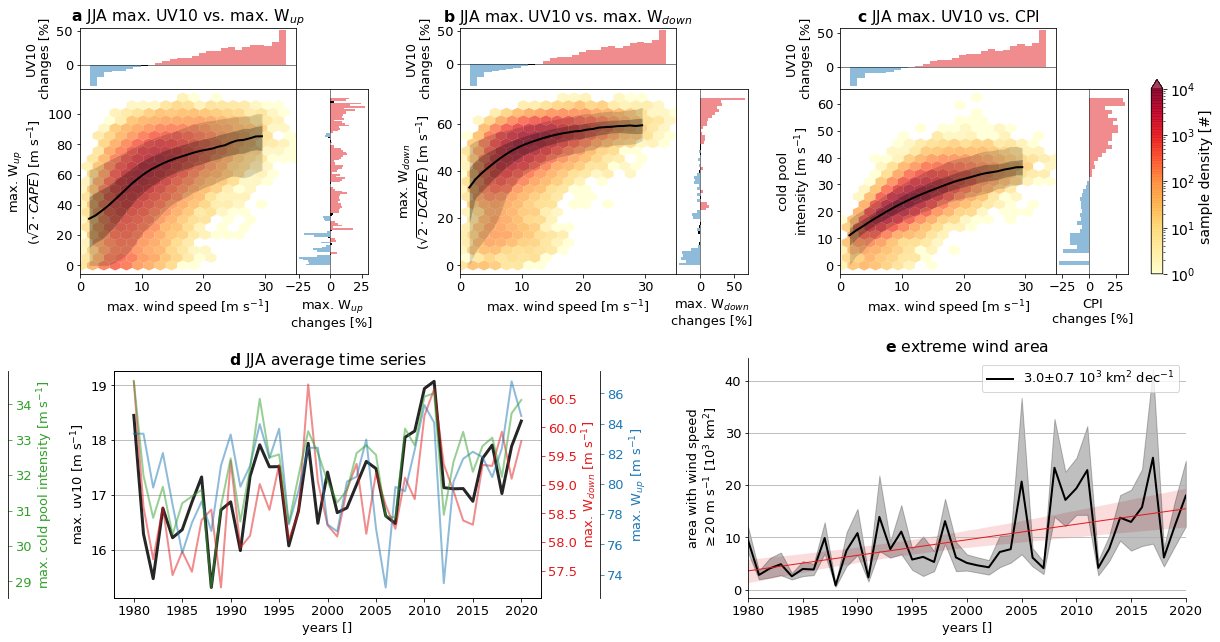

In [72]:
pp=100
ar = 1
dt = -1
pp_extr = 90


fig = plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 13})
rgsLableABC=list(string.ascii_lowercase)

foc_vars = ['CAPE', 'DCAPE', 'CPI']
foc_vars_derived = ['max. W$_{up}$', 'max. W$_{down}$', 'CPI']
x_size = 0.25
x_space = 0.08
for va in range(len(foc_vars)):
    gs1 = gridspec.GridSpec(4,4)
    gs1.update(left=0.05+(x_size+x_space)*va, right=0.05+(x_size+x_space)*va+x_size,
       bottom=0.57, top=0.95,
       wspace=0, hspace=0)
    
    ax = plt.subplot(gs1[1:,:3])
    uv_sel = var_stats_all[:,:,12,pp,ar,list(var_name).index('uv10')]
    if foc_vars[va] == 'CAPE':
        wmax_sel = (2*var_stats_all[:,:,12,pp,ar,list(var_name).index('cape')])**0.5
        axlabel = 'max. W$_{up}$\n($\sqrt{2 \cdot CAPE}$) [m s$^{-1}$]'
    if foc_vars[va] == 'DCAPE':
        wmax_sel = (2*var_stats_all[:,:,12,pp,ar,list(var_name).index('dcape')])**0.5
        axlabel = 'max. W$_{down}$\n($\sqrt{2 \cdot DCAPE}$) [m s$^{-1}$]'
    if foc_vars[va] == 'CPI':
        wmax_sel = var_stats_all[:,:,12,pp,ar,list(var_name).index('cpi')]
        axlabel = 'cold pool\nintensity [m s$^{-1}$]'

    image = plt.hexbin(uv_sel.flatten(), wmax_sel.flatten(), cmap = 'YlOrRd', 
                       gridsize=20, mincnt=1, alpha = 0.75, linewidths=0, vmax=10000, bins='log')

    x_bin = np.arange(0,100,1)
    x_binc = (x_bin[1:] + x_bin[:-1])/2
    overlap = 1 # m/s
    percentiles = (1,5,25,50,75,95,99)
    bw_bins_cape = np.zeros((len(x_binc), len(percentiles))); bw_bins_cape[:] = np.nan
    for ii in range(len(x_binc)):
        data_sel = (uv_sel >= x_bin[ii]-overlap) & (uv_sel < x_bin[ii+1]+overlap)
        if sum(data_sel) > 100:
            bw_bins_cape[ii,:] = np.percentile(wmax_sel[data_sel], percentiles)

    plt.fill_between(x_binc, bw_bins_cape[:,1], y2=bw_bins_cape[:,5], 
                     color='k', alpha=0.15, linewidths=0)
    plt.fill_between(x_binc, bw_bins_cape[:,2], y2=bw_bins_cape[:,4], 
                     color='k', alpha=0.25, linewidths=0)
    plt.plot(x_binc, bw_bins_cape[:,3], c='k', lw=2)

    ax.set_xlabel('max. wind speed [m s$^{-1}$]')
    ax.set_ylabel(axlabel)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim([0,35])
    
    # show pdf shift
    ax2 = plt.subplot(gs1[0,:3])
    # do bootstrapping on this data to test for stat. significance
    bs_samples = 100
    hist_curr_samples = np.zeros((bs_samples, 2, len(x_binc))); hist_curr_samples[:] = np.nan
    for bs in range(bs_samples):
        rand_years = np.array([randrange(0, 19) for ii in range(20)])
        past_years = uv_sel[:20][rand_years]
        hist_past = np.array([
                            np.sum((past_years.flatten() >= x_bin[ii]-overlap) & 
                            (past_years.flatten() < x_bin[ii+1]+overlap))
                         for ii in range(len(x_binc))
                         ])
        curr_years = uv_sel[-20:][rand_years]
        hist_curr = np.array([
                            np.sum((curr_years.flatten() >= x_bin[ii]-overlap) & 
                            (curr_years.flatten() < x_bin[ii+1]+overlap))
                         for ii in range(len(x_binc))
                         ])
        hist_curr_samples[bs,0,:] = hist_past
        hist_curr_samples[bs,1,:] = hist_curr

    change = ((hist_curr_samples[:,1,:]-hist_curr_samples[:,0,:])/hist_curr_samples[:,0,:])*100
    change[:, np.mean(hist_curr_samples[:,0,:], axis=0) < 100] = np.nan
    change_sig = np.zeros((hist_curr_samples.shape[2])); change_sig[:] = np.nan
    for ii in range(hist_curr_samples.shape[2]):
        try:
            change_sig[ii] = scipy.stats.mannwhitneyu(hist_curr_samples[:,0,ii], hist_curr_samples[:,1,ii])[1]
#             change_sig[ii] = scipy.stats.ttest_ind(hist_curr_samples[:,0,ii], hist_curr_samples[:,1,ii])[1]
        except:
            continue
    change_med = np.nanmedian(change, axis=0)

    plt.bar(x_binc[change_med>=0], change_med[change_med>=0], color='#e31a1c', alpha=0.5, width = 1)
    plt.bar(x_binc[change_med<0], change_med[change_med<0], color='#1f78b4', alpha=0.5, width = 1)
    try:
        plt.bar(x_binc[change_sig>0.05], change_med[change_sig>0.025], color='k', alpha=1, width = 1)
    except:
        continue
    plt.axhline(y=0, color='k', linestyle='-', lw=0.5)
    ax2.set_ylabel('UV10\nchanges [%]')
    ax.set_xlim([0,35])
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    
    # show pdf shift
    ax3 = plt.subplot(gs1[1:,3])
    hist_curr_samples = np.zeros((bs_samples, 2, len(x_binc))); hist_curr_samples[:] = np.nan
    for bs in range(bs_samples):
        rand_years = np.array([randrange(0, 19) for ii in range(20)])
        past_years = wmax_sel[:20][rand_years]
        hist_past = np.array([
                                np.sum((past_years.flatten() >= x_bin[ii]-overlap) & 
                                (past_years.flatten() < x_bin[ii+1]+overlap))
                             for ii in range(len(x_binc))
                             ])
        curr_years = wmax_sel[-20:][rand_years]
        hist_curr = np.array([
                                np.sum((curr_years.flatten() >= x_bin[ii]-overlap) & 
                                (curr_years.flatten() < x_bin[ii+1]+overlap))
                             for ii in range(len(x_binc))
                             ])
        hist_curr_samples[bs,0,:] = hist_past
        hist_curr_samples[bs,1,:] = hist_curr
        
    change = ((hist_curr_samples[:,1,:]-hist_curr_samples[:,0,:])/hist_curr_samples[:,0,:])*100
    change[:, np.mean(hist_curr_samples[:,0,:], axis=0) < 100] = np.nan
    change_sig = np.zeros((hist_curr_samples.shape[2])); change_sig[:] = np.nan
    for ii in range(hist_curr_samples.shape[2]):
        try:
            change_sig[ii] = scipy.stats.mannwhitneyu(hist_curr_samples[:,0,ii], hist_curr_samples[:,1,ii])[1]
#             change_sig[ii] = scipy.stats.ttest_ind(hist_curr_samples[:,0,ii], hist_curr_samples[:,1,ii])[1]
        except:
            continue
    change_med = np.nanmedian(change, axis=0)
    
    plt.barh(x_binc[change_med >= 0], change_med[change_med >= 0], 1, color='#e31a1c', alpha=0.5)
    plt.barh(x_binc[change_med < 0], change_med[change_med < 0], 1, color='#1f78b4', alpha=0.5)
    plt.barh(x_binc[change_sig>0.025], change_med[change_sig>0.025], 1, color='k', alpha=1)
#     if len(x_binc[change_sig>0.05]) !=0:
#         plt.barh(x_binc[change_sig>0.05], change[change_sig>0.05], 1, color='gray', alpha=1)
    plt.axvline(x=0, color='k', linestyle='-', lw=0.5)
    ax3.set_xlabel(foc_vars_derived[va]+'\nchanges [%]')
    frame1 = plt.gca()
    frame1.axes.get_yaxis().set_visible(False)
    
#     sns.kdeplot(wmax_sel[:15].flatten(), c='k', vertical=True)
#     sns.kdeplot(wmax_sel[-15:].flatten(), c='r', vertical=True)


    ax2.set_title(r"$\bf{" + rgsLableABC[va] + "}$"+' JJA max. UV10 vs. '+foc_vars_derived[va])

CbarAx = axes([0.98, 0.57, 0.01, 0.3])
cb = colorbar(image, cax = CbarAx, orientation='vertical', extend='max') #,spacing='uniform')#, ticks=np.linspace(0,0.0015,41))
cb.ax.tick_params(labelsize=14)
cb.set_label('sample density [#]', fontsize=14)


# =================================================================
# plot additional statistics to show changes over time
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.08, right=0.45,
   bottom=0.07,top=0.42,
   wspace=1, hspace=0.25)


# plot incrase in varius parameters over time
ax = plt.subplot(gs1[0,0])
# pp=100
# ar = 0
# uv10_yy = np.nanmean(var_stats_all[:,:,12,pp,ar,list(var_name).index('uv10')], axis=1)
uv10_yy = np.nanpercentile(var_stats_all[:,:,12,pp,ar,list(var_name).index('uv10')], pp_extr,axis=1)
plt.plot(years[:], uv10_yy, c='k', 
         lw=3, zorder=10, alpha=0.85)
ax.set_ylabel('max. uv10 [m s$^{-1}$]')
ax.axis('auto')
ax.set_autoscaley_on(True)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False) 
# ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_title(r"$\bf{" + rgsLableABC[3] + "}$"+' JJA average time series')

ax1 = ax.twinx()
color = '#e31a1c'
dcape_yy = np.nanpercentile((2*var_stats_all[:,:,12,pp,ar,list(var_name).index('dcape')])**0.5, pp_extr, axis=1)
plt.plot(years[:], dcape_yy, 
         c=color, alpha=0.5, lw=2)
ax1.yaxis.label.set_color(color)
ax1.set_ylabel('max. W$_{down}$ [m s$^{-1}$]')
ax1.tick_params(axis='y', colors=color)
ax1.axis('auto')
ax1.set_autoscaley_on(True)

ax2 = ax.twinx()
color = '#1f78b4'
cape_yy = np.nanpercentile((2*var_stats_all[:,:,12,pp,ar,list(var_name).index('cape')])**0.5, pp_extr, axis=1)
plt.plot(years[:], cape_yy, 
         c=color, alpha=0.5, lw=2)
ax2.yaxis.label.set_color(color)
ax2.set_ylabel('max. W$_{up}$ [m s$^{-1}$]')
ax2.tick_params(axis='y', colors=color)
ax2.spines["right"].set_position(("axes", 1.14))

ax3 = ax.twinx()
color = '#33a02c'
cpi_yy = np.nanpercentile((var_stats_all[:,:,12,pp,ar,list(var_name).index('cpi')]), pp_extr, axis=1)
plt.plot(years[:], cpi_yy, 
         c=color, alpha=0.5, lw=2)
ax3.yaxis.label.set_color(color)
ax3.set_ylabel('max. cold pool intensity [m s$^{-1}$]')
ax3.tick_params(axis='y', colors=color)
ax3.spines["right"].set_position(("axes", -0.25))
ax.set_xlabel('years []')
ax.grid(axis='y')

# # add table with trend and correlation information
# columns = ['trend [m s$^{-1}$ dec$^{-1}$]','Spearman\'s r']
# rows = ['UV10','max. W$_{down}$','max. W$_{up}$','CPI']
# data = [
#         [str(np.round(scipy.stats.linregress(years, uv10_yy)[0]*10.,2))+ '$\pm$' +str(np.round(scipy.stats.linregress(years, uv10_yy)[4]*10.,2)), str(np.round(scipy.stats.pearsonr(uv10_yy,uv10_yy)[0],2))],
#         [str(np.round(scipy.stats.linregress(years, dcape_yy)[0]*10.,2))+ '$\pm$' +str(np.round(scipy.stats.linregress(years, dcape_yy)[4]*10.,2)), str(np.round(scipy.stats.pearsonr(dcape_yy,uv10_yy)[0],2))],
#         [str(np.round(scipy.stats.linregress(years, cape_yy)[0]*10.,2))+ '$\pm$' +str(np.round(scipy.stats.linregress(years, cape_yy)[4]*10.,2)), str(np.round(scipy.stats.pearsonr(cape_yy,uv10_yy)[0],2))],
#         [str(np.round(scipy.stats.linregress(years, cpi_yy)[0]*10.,2))+ '$\pm$' +str(np.round(scipy.stats.linregress(years, cpi_yy)[4]*10.,2)), str(np.round(scipy.stats.pearsonr(cpi_yy,uv10_yy)[0],2))]
# ][::-1]

# n_rows = len(data)
# cell_text = []
# for row in range(n_rows):
#     y_offset = data[row]
#     cell_text.append([x for x in y_offset])
  
# # Reverse colors and text labels to display
# # the last value at the top.
# # colors = colors[::-1]
# cell_text.reverse()
# the_table = plt.table(cellText=cell_text,
#                       rowLabels=rows,
#                       colLabels=columns,
#                       loc='bottom',
#                       cellLoc='center')
# the_table.scale(1, 1.4)




gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.63, right=1.01,
   bottom=0.07,top=0.44,
   wspace=0.4, hspace=0.25)
# plot incrase in 20 m/s area over time
ax = plt.subplot(gs1[0,0])
iqd = np.nanpercentile(np.sum(bs_dataset[:,:,:,:], axis=(1,2)), (10,90), axis=(1))/1000**3

regression = scipy.stats.linregress(years, np.nansum(area_coverages_all[:,:,12,list(area_types).index(area)], axis=(1))/1000**3)
plt.plot(years, np.nansum(area_coverages_all[:,:,12,list(area_types).index(area)], axis=(1))/1000**3, 
         c='k', lw=2, label = str(np.round(regression[0]*10,1))+
                              '$\pm$' + str(np.round(regression[4]*10.,1)) + ' 10$^3$ km$^{2}$ dec$^{-1}$')
sns.regplot(years, np.nansum(area_coverages_all[:,:,12,list(area_types).index(area)], axis=(1))/1000**3, 
            color='#e31a1c', scatter_kws={'s':0}, line_kws={'linewidth':1}) # , ci = None
plt.fill_between(years, iqd[0,:], y2 = iqd[1,:], color='k', alpha=0.25)
plt.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('years []')
ax.set_ylabel('area with wind speed\n$\geq$20 m s$^{-1}$ [10$^3$ km$^{2}$]')
ax.grid(axis='y')
ax.set_title(r"$\bf{" + rgsLableABC[4] + "}$"+' extreme wind area')


sPlotFile=''
sPlotName= 'JJA_conditional-changes.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

### Scatter plots showing correlations between predictor varaibles

In [110]:
# add table with trend and correlation information
columns = ['trend [m s$^{-1}$ dec$^{-1}$]','Spearman\'s r']
rows = ['UV10','max. W$_{down}$','max. W$_{up}$','CPI']
data = [
        [str(np.round(scipy.stats.linregress(years, uv10_yy)[0]*10.,2))+ '$\pm$' +str(np.round(scipy.stats.linregress(years, uv10_yy)[4]*10.,2)), str(np.round(scipy.stats.pearsonr(uv10_yy,uv10_yy)[0],2))],
        [str(np.round(scipy.stats.linregress(years, cape_yy)[0]*10.,2))+ '$\pm$' +str(np.round(scipy.stats.linregress(years, cape_yy)[4]*10.,2)), str(np.round(scipy.stats.pearsonr(cape_yy,uv10_yy)[0],2))],
        [str(np.round(scipy.stats.linregress(years, dcape_yy)[0]*10.,2))+ '$\pm$' +str(np.round(scipy.stats.linregress(years, dcape_yy)[4]*10.,2)), str(np.round(scipy.stats.pearsonr(dcape_yy,uv10_yy)[0],2))],
        [str(np.round(scipy.stats.linregress(years, cpi_yy)[0]*10.,2))+ '$\pm$' +str(np.round(scipy.stats.linregress(years, cpi_yy)[4]*10.,2)), str(np.round(scipy.stats.pearsonr(cpi_yy,uv10_yy)[0],2))]
][::-1]

n_rows = len(data)
cell_text = []
for row in range(n_rows):
    y_offset = data[row]
    cell_text.append([x for x in y_offset])
  
# Reverse colors and text labels to display
# the last value at the top.
# colors = colors[::-1]
cell_text.reverse()

In [106]:
cell_text

[['0.33$\\pm$0.1', '1.0'],
 ['0.28$\\pm$0.11', '0.69'],
 ['0.45$\\pm$0.4', '0.52'],
 ['0.41$\\pm$0.15', '0.89']]

        Plot map to: JJA_predictor_correlations.pdf


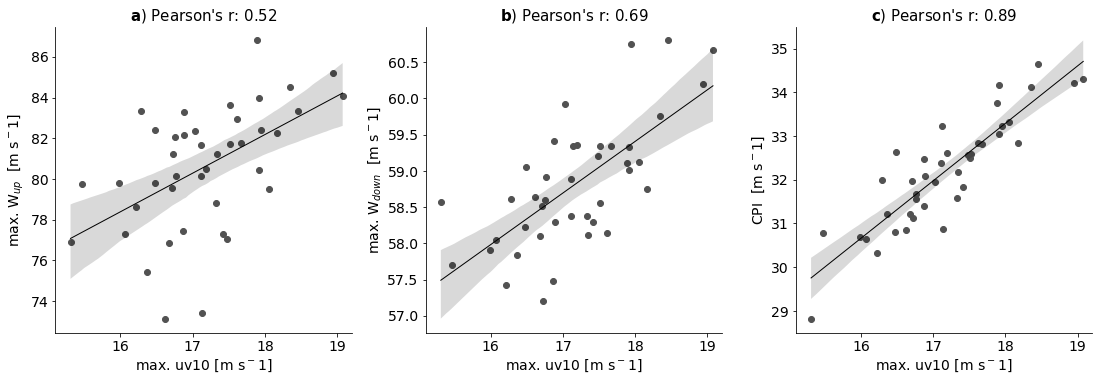

In [112]:
fig = plt.figure(figsize=(16,5))
plt.rcParams.update({'font.size': 14})
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.05, right=0.95,
   bottom=0.1, top=0.95,
   wspace=0.25, hspace=0)

foc_vars_derived = ['max. W$_{up}$', 'max. W$_{down}$', 'CPI']
for va in range(len(foc_vars_derived)):
    ax = plt.subplot(gs1[0,va])
    if foc_vars_derived[va] == 'max. W$_{up}$':
        data = cape_yy
    if foc_vars_derived[va] == 'max. W$_{down}$':
        data = dcape_yy
    if foc_vars_derived[va] == 'CPI':
        data = cpi_yy
    
    plt.scatter(uv10_yy,data, c='#525252')
    sns.regplot(uv10_yy,data, 
                color='k', scatter_kws={'s':0}, line_kws={'linewidth':1}) # , ci = None
    plt.xlim([15.1,19.2])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('max. uv10 [m s${^-1}$]')
    ax.set_ylabel(foc_vars_derived[va]+'  [m s${^-1}$]')
    ax.set_title(r"$\bf{" + rgsLableABC[va] + "}$)"+' Pearson\'s r: '+cell_text[va+1][1], fontsize=15)
    
sPlotFile=''
sPlotName= 'JJA_predictor_correlations.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)